# **Banco de Preprocesamiento de Imágenes (Melanoma CNN)**
Explorar, validar y definir los perfiles de preprocesamiento que se aplicarán a las imágenes dermatoscópicas antes del entrenamiento de la red neuronal. Este cuaderno implementa, de forma modular y visual, los pasos de limpieza de artefactos (viñeta y pelo), segmentación de la lesión, y conversión de color, generando un banco experimental reproducible para construir los perfiles `RGB`, `RGB+H` y `RGB+S`.

El melanoma es un tipo agresivo de cáncer de piel, y la detección temprana mediante imágenes dermatoscópicas requiere **eliminar artefactos visuales que podrían confundir al modelo** (bordes negros del dermatoscopio, pelos, etc.). En este notebook se definirá el **pipeline base de preprocesamiento**, validando visualmente los resultados y fijando los perfiles de color y limpieza que alimentarán los experimentos de entrenamiento posteriores.

## **Configuración del entorno**
El primer paso antes de procesar cualquier imagen es garantizar que el entorno sea **reproducible y determinista.** En proyectos de visión por computador, incluso pequeñas diferencias en la inicialización de librerías, semillas aleatorias o versiones de dependencias pueden provocar resultados inconsistentes entre ejecuciones.

In [27]:
# General imports
import os
from pathlib import Path
import random
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import ImageOps

In [16]:
# Project imports
from src.utils.config import load_config
from src.utils.reproducibility import set_global_determinism
from src.preproc.vignette import *
from src.preproc.hair import remove_hair, compose_lesion_preserved
from src.preproc.segment import segment_lesion
from src.preproc.colors import build_tensor as build_tensor_colors
from src.preproc.utils_io import (
    imread_rgb,
    side_by_side,
    three_panel,
    four_panel,
    six_panel,
    ensure_dir,
    pick_random_images,
    list_images
)

In [4]:
# Set working directory to project root
os.chdir(Path.cwd().parent)

In [5]:
# Load configuration: Base config and global parameters
CFG = load_config("config/base.yaml")

# Set global reproducibility
IMG_SIZE = int(CFG["img_size"])
SEED = CFG["seed"]
RESULTS_DIR = Path(CFG["paths"]["results_dir"])
CACHE_DIR = Path(CFG["paths"]["cache_dir"])

print("[INFO] Project configured successfully.")
print(f"[INFO] Image size: {IMG_SIZE} px | Seed: {SEED}")
print(f"[INFO] Cache directory: {CACHE_DIR}")
print(f"[INFO] Results directory: {RESULTS_DIR}")

[INFO] Project configured successfully.
[INFO] Image size: 224 px | Seed: 1337
[INFO] Cache directory: .cache\images
[INFO] Results directory: results


In [6]:
# Set random seeds and global reproducibility
set_global_determinism(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Matplotlib visual adjustments
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.facecolor"] = "#fafafa"

print("[OK] Environment initialized and determinism activated.")

[OK] Determinism configured with seed=1337
[OK] Environment initialized and determinism activated.


In [7]:
# Verify local cache directories
orig_root = CACHE_DIR / "original"
proc_root = CACHE_DIR / "processed"
preview_root = CACHE_DIR/ "preview"

for d in [orig_root, proc_root, preview_root]:
    ensure_dir(d)

print(f"[INFO] Original images directory: {orig_root}")
print(f"[INFO] Processed images directory: {proc_root}")
print(f"[INFO] Previews directory: {preview_root}")

[INFO] Original images directory: .cache\images\original
[INFO] Processed images directory: .cache\images\processed
[INFO] Previews directory: .cache\images\preview


## **Selección de imágenes de muestra**
Selección de un conjunto reducido de imágenes representativas de ambos grupos (Benign y Malignant), tomadas del split train. Se visualizará un mosaico original de las muestras seleccionadas para verificar la calidad de partida y establecer una referencia visual previa al preprocesamiento.

In [8]:
SAMPLE_SIZE = 24 # Number of sample images to select
sample_items = pick_random_images(str(orig_root), k=SAMPLE_SIZE)
print(f"[INFO] Sampled {SAMPLE_SIZE} random images for visualization.")

[INFO] Sampled 24 random images for visualization.


In [9]:
# Mosaic for visualization split function
def show_grid(items, title="Mosaic", img_size=IMG_SIZE, cols=6):
    if not items:
        print("[WARN] No images to display.")
        return
    rows = math.ceil(len(items)/cols)
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i, (split, label, path) in enumerate(items[:cols*rows]):
        try:
            im = Image.open(path).convert("RGB").resize((img_size, img_size))
            ax = plt.subplot(rows, cols, i+1)
            ax.imshow(im)
            ax.set_title(f"{label}", fontsize=8)
            ax.axis("off")
        except Exception as e:
            ax = plt.subplot(rows, cols, i+1)
            ax.set_title("ERR", fontsize=8)
            ax.axis("off")
    plt.suptitle(title, y=0.98)
    plt.tight_layout()
    plt.show()

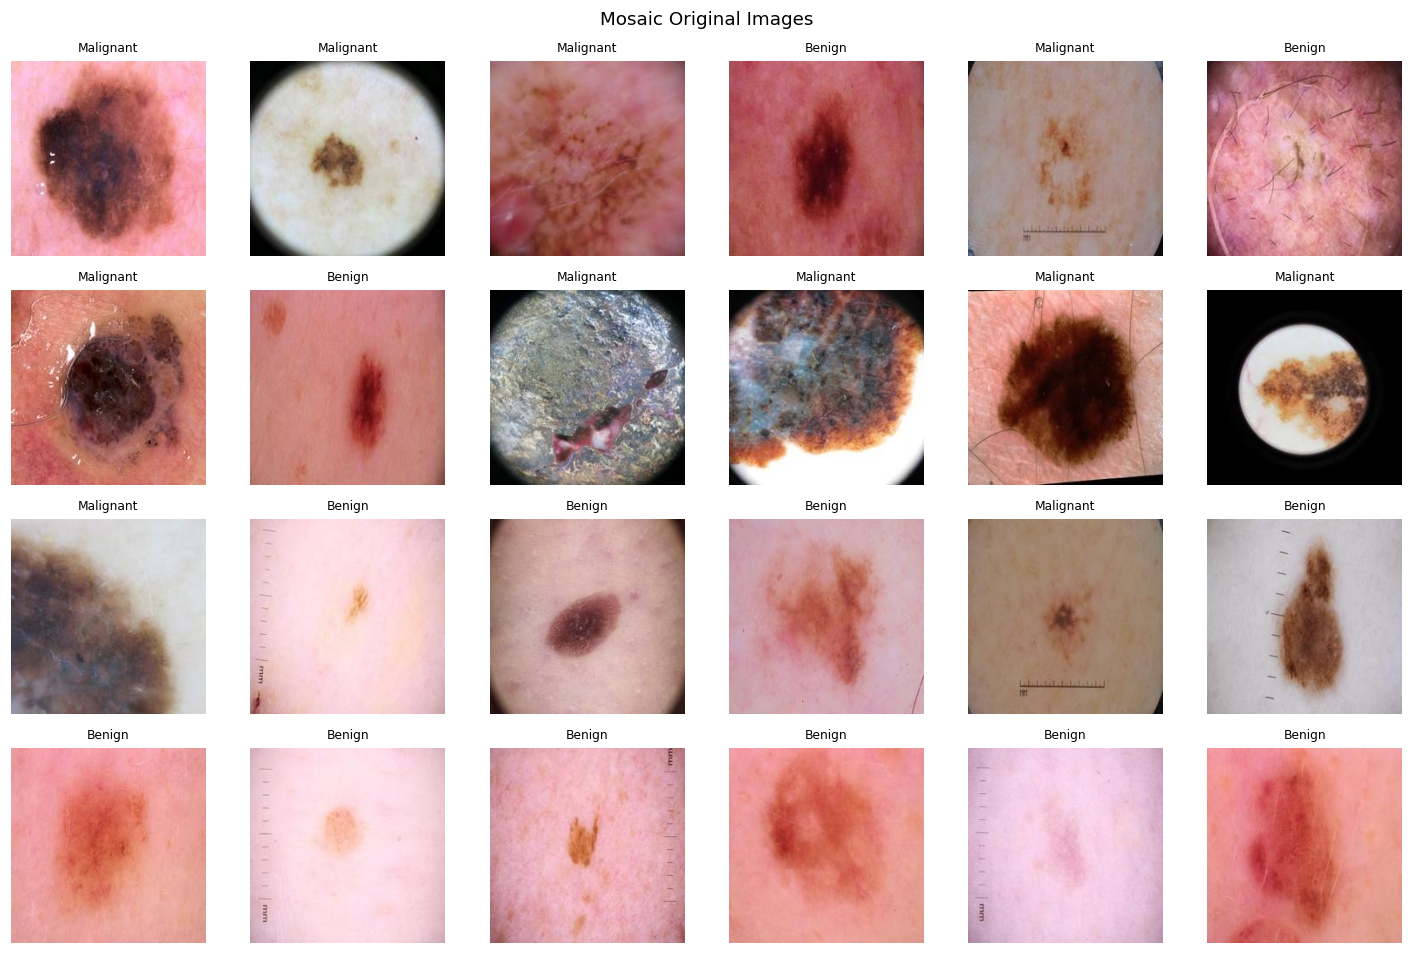

In [10]:
show_grid(sample_items, title="Mosaic Original Images", img_size=IMG_SIZE)

## **Detección y corrección de viñeta**
Aplicación del módulo `detect_and_mask_vignette()` sobre imágenes con y sin borde oscuro. Se mostrará una comparativa lado a lado (original vs corregida). Se analizará la proporción de píxeles oscuros (dark_ratio) y la bandera *vignette detected*.

**Propósito:** Verificar si el viñeteado es un fenómeno significativo y decidir si conviene aplicar esta corrección de manera global o selectiva.

In [14]:
def _preview_vignette(img: Image.Image, res: VignetteResult) -> Image.Image:
    """
    Creates a 4-panel visualization:
    - Original
    - Keep-mask (white = preserved)
    - Overlay (green ONLY where it’s cut: outside the disk)
    - Final (black border applied) → this is what the network would see
    Args:
        - img (Image.Image): Original input image.
        - res (VignetteResult): Object containing the ring mask and the final processed image.
    Returns:
        - Image.Image: A composite 4-panel image showing the intermediate vignette steps.
    """
    from PIL import ImageOps
    keep = res.ring_mask.astype(np.uint8)          # 1 = keep, 0 = cut
    cut  = (1 - keep).astype(np.uint8)             # 1 = region to cut (outer ring)
    keep_rgb = Image.fromarray((keep * 255)).convert("RGB")
    # overlay: color ONLY the cut region (cut), not the entire image
    cut_gray = Image.fromarray((cut * 255)).convert("L")
    cut_col  = ImageOps.colorize(cut_gray, black="black", white="lime")
    overlay  = Image.blend(img, cut_col, alpha=0.45)
    final_img = res.img_fixed                      # image with black border applied

    return four_panel(
        img, keep_rgb, overlay, final_img,
        titles=("Original", "Keep-mask (1=Useful)", "Overlay (Cut Area)", "Final (Black Border)")
    )

In [28]:
picks = pick_random_images(orig_root)
if not picks:
    print("[WARN] No external_val images found.")
else:
    print(f"Found {len(picks)} images in external_val.")

Found 5 images in external_val.


[VIGNETTE] Picks: [('train', 'Malignant', '.cache\\images\\original\\train\\Malignant\\176.jpg'), ('train', 'Malignant', '.cache\\images\\original\\train\\Malignant\\1688.jpg'), ('train', 'Malignant', '.cache\\images\\original\\train\\Malignant\\4896.jpg'), ('train', 'Benign', '.cache\\images\\original\\train\\Benign\\4626.jpg'), ('test', 'Malignant', '.cache\\images\\original\\test\\Malignant\\5800.jpg')]


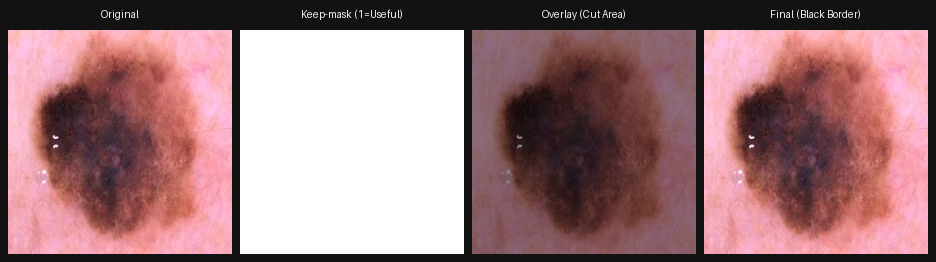

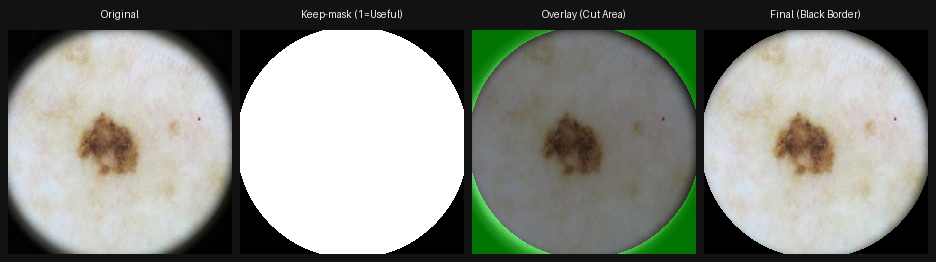

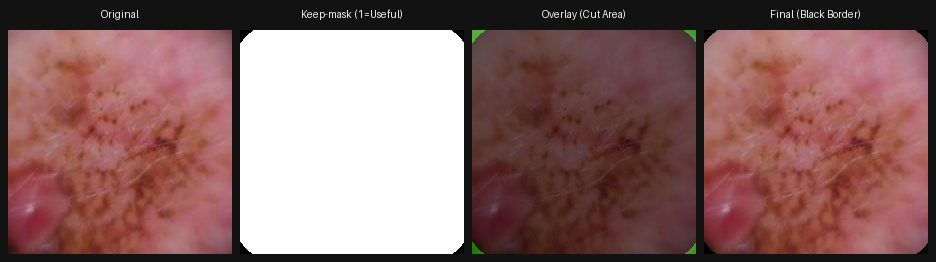

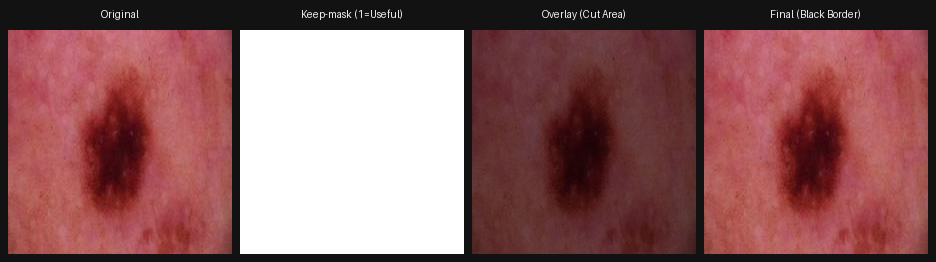

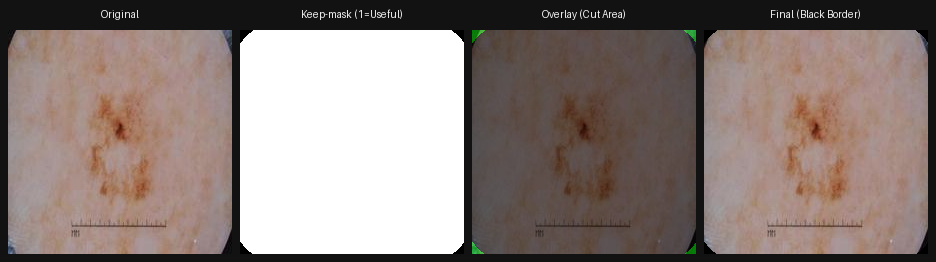

In [29]:
cache_dir = proc_root / "_test" / "vignette"
cache_dir.mkdir(parents=True, exist_ok=True)

print("[VIGNETTE] Picks:", picks)
for split, label, path in picks:
    img = imread_rgb(path, img_size=224)
    res = detect_and_mask_vignette(img)
    panel = _preview_vignette(img, res)
    display(panel)
    out = cache_dir / f"{split}__{label}__{Path(path).stem}__vig.png"
    panel.save(out)

## **Eliminación de pelos y preservación de la lesión**
Aplicación del módulo `remove_hair()` (basado en Black-Hat + inpainting, estilo *DullRazor*) sobre imágenes dermatoscópicas, en conjunto con `segment_lesion()` para aislar la región de interés. Se muestra una comparativa visual del proceso:

1. Imagen original (ya corregida por viñeteado si corresponde)
2. Máscara de pelos detectados
3. Imagen sin pelos (*hair-removed*)
4. Imagen final con **lesión preservada** sobre fondo limpio.

**Propósito:** Evaluar la efectividad del algoritmo de eliminación de pelos y su impacto en la segmentación de la lesión. Esta etapa busca determinar si la corrección debe aplicarse de manera **global o selectiva**, preservando siempre la información original dentro de la lesión segmentada.

In [30]:
OUT_A = preview_root / "_test" / "hair_3panel"
OUT_B = preview_root / "_test" / "hair_lesion_preserved"

ensure_dir(OUT_A); ensure_dir(OUT_B)

WindowsPath('.cache/images/preview/_test/hair_lesion_preserved')

In [26]:
picks = pick_random_images(orig_root)

if not picks:
    print("[WARN] No external_val images found.")
else:
    print(f"Found {len(picks)} images in external_val.")

Found 5 images in external_val.


[HAIR A] train/Malignant — hair coverage = 0.0894


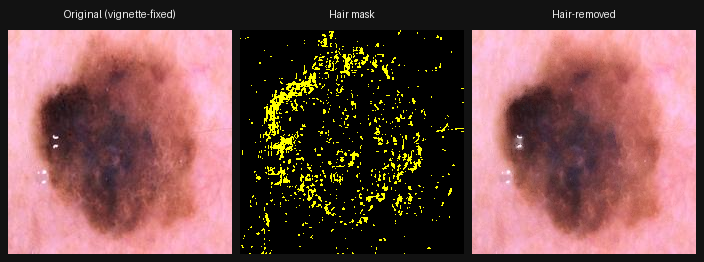

[HAIR B] train/Malignant — lesion-preserved composition


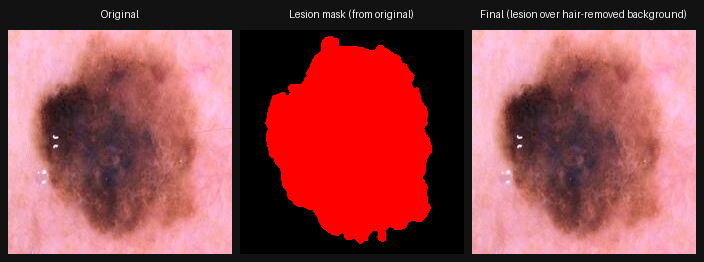

[HAIR A] train/Malignant — hair coverage = 0.0557


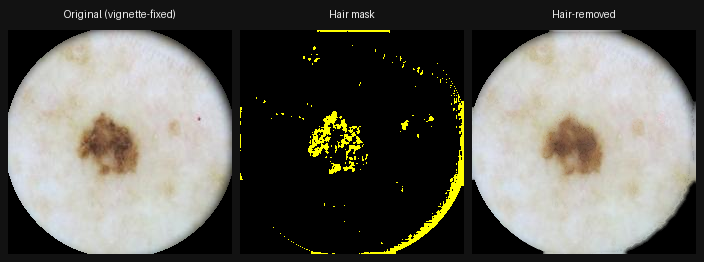

[HAIR B] train/Malignant — lesion-preserved composition


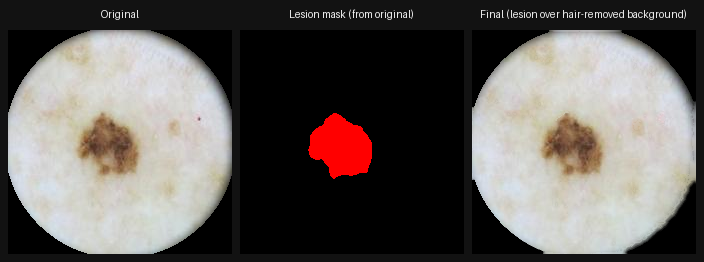

[HAIR A] train/Malignant — hair coverage = 0.0490


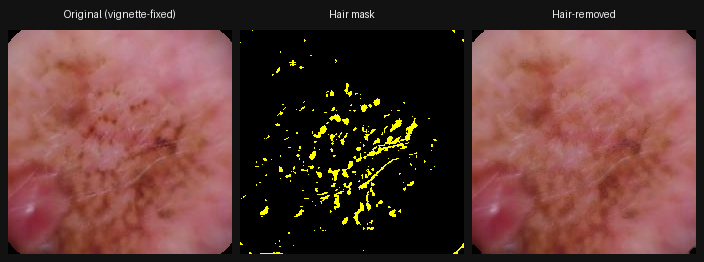

[HAIR B] train/Malignant — lesion-preserved composition


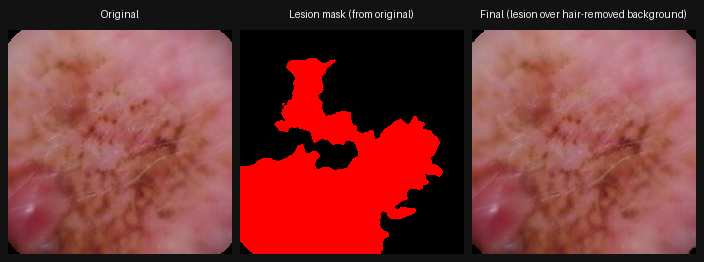

[HAIR A] train/Benign — hair coverage = 0.0304


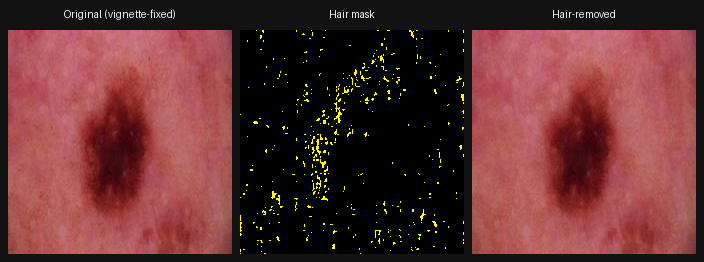

[HAIR B] train/Benign — lesion-preserved composition


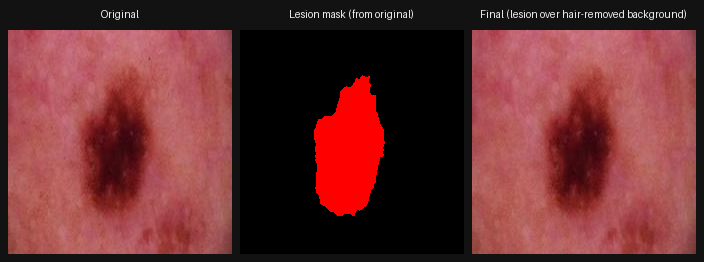

[HAIR A] test/Malignant — hair coverage = 0.0394


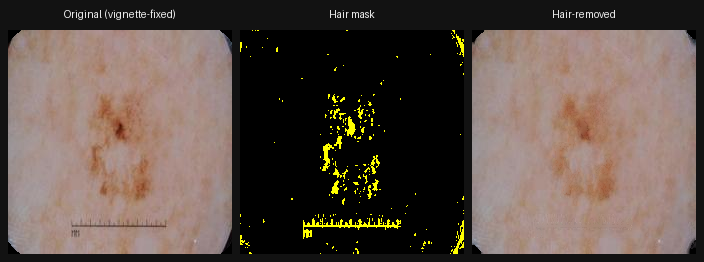

[HAIR B] test/Malignant — lesion-preserved composition


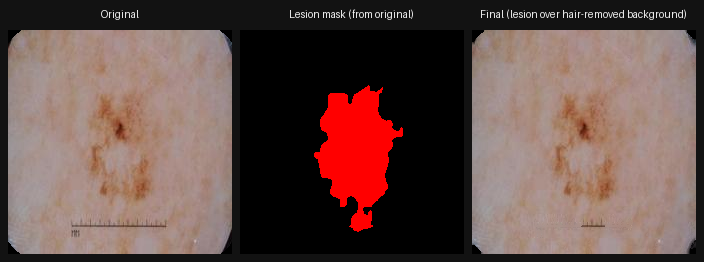

In [32]:
for split, label, path in picks:
    # 1) Correct vignette first (recommended before segmentation)
    img = imread_rgb(path, img_size=IMG_SIZE)
    vres = detect_and_mask_vignette(img)
    img_v = vres.img_fixed                    # PIL Image
    a_orig = np.asarray(img_v, dtype=np.uint8)

    # 2) Segment lesion on the ORIGINAL (vignette-corrected) image
    mask_raw, lesion_rgb = segment_lesion(a_orig, size=(IMG_SIZE, IMG_SIZE))
    lesion_mask = mask_raw  # uint8 0/255

    # 3) Remove hair on the FULL image
    clean, hair_mask, cov = remove_hair(a_orig)

    # --- Panel A: Original | Hair mask | Hair-removed (for inspection)
    mask_vis = Image.fromarray(hair_mask).convert("L")
    mask_rgb = ImageOps.colorize(mask_vis, black="black", white="yellow").convert("RGB")
    panelA = three_panel(
        img_v,
        mask_rgb,
        Image.fromarray(clean),
        titles=("Original (vignette-fixed)", "Hair mask", "Hair-removed")
    )

    # Show on screen (Notebook display)
    print(f"[HAIR A] {split}/{label} — hair coverage = {cov:.4f}")
    display(panelA)

    # Save in .cache/_test/hair
    stem = f"{split}__{label}__{Path(path).stem}"
    panelA.save(OUT_A / f"{stem}__A_hair3.png")

    # 4) Compose: keep ORIGINAL pixels inside the lesion;
    #             use hair-removed background outside the lesion
    final_lp = compose_lesion_preserved(a_orig, clean, lesion_mask)

    # --- Panel B: Original | Lesion mask | Final (lesion-preserved)
    mask_vis2 = Image.fromarray(lesion_mask).convert("L")
    mask_rgb2 = ImageOps.colorize(mask_vis2, black="black", white="red").convert("RGB")
    panelB = three_panel(
        img_v,
        mask_rgb2,
        Image.fromarray(final_lp),
        titles=("Original", "Lesion mask (from original)", "Final (lesion over hair-removed background)")
    )

    # Show on screen
    print(f"[HAIR B] {split}/{label} — lesion-preserved composition")
    display(panelB)

    # Save
    panelB.save(OUT_B / f"{stem}__B_lp3.png")